In [71]:
import bisect
# import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
# from networkx.drawing.nx_pydot import graphviz_layout
import pydot

import dalmatian 

from helper import *
from scipy.stats import iqr

from scipy.special import logsumexp

# Specify inputs 

In [72]:
# Specify wbc and treatment files for growth kinetics 

patient = 'RP-1918_JB-0373'

wbc_file = 'data/JB_0373_wbc.txt'

# Load treatment file 
treatment = pd.read_csv("data/JB_0373_tx.txt", sep = '\t')


In [74]:
# Get input files from Terra through dalmatian

workspace ='broad-firecloud-ibmwatson/Brown_Getz_IBM_99-224_Exomes_Liang'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs'], sep='\t')
abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv'], sep='\t')

In [75]:
mcmc_df

,Patient_ID,Sample_ID,Iteration,Cluster_ID,Abundance
0,RP-1918_JB-0373,RP-1918_JB-0373-T-04_v1_Exome_OnPrem,0,1,6
1,RP-1918_JB-0373,RP-1918_JB-0373-T-04_v1_Exome_OnPrem,0,2,11
2,RP-1918_JB-0373,RP-1918_JB-0373-T-04_v1_Exome_OnPrem,0,3,3
3,RP-1918_JB-0373,RP-1918_JB-0373-T-04_v1_Exome_OnPrem,0,4,25
4,RP-1918_JB-0373,RP-1918_JB-0373-T-04_v1_Exome_OnPrem,0,5,43
...,...,...,...,...,...
53995,RP-1918_JB-0373,RP-1918_JB-0373-T-11_v1_Exome_OnPrem,499,5,1
53996,RP-1918_JB-0373,RP-1918_JB-0373-T-11_v1_Exome_OnPrem,499,6,2
53997,RP-1918_JB-0373,RP-1918_JB-0373-T-11_v1_Exome_OnPrem,499,7,88
53998,RP-1918_JB-0373,RP-1918_JB-0373-T-11_v1_Exome_OnPrem,499,8,1


# Helper functions to parse the input files 

In [76]:
def load_wbc_file(file):
    """
    Parse wbc file 
    
    Args:
        wbc file
    
    Returns:
        variables as a list
    
    """

    df = pd.read_csv(file, sep ='\t')

    # Get all time points 
    times = df.dfd.tolist()
    
    # Get times that are in the interpolation range
    t = pd.notna(df['sample_id'])
    sample_time_index = [i for i, x in enumerate(t) if x]
    first_sample_index  = sample_time_index[0]
    last_sample_index = sample_time_index[-1]
    df_interpolate = df.iloc[first_sample_index:last_sample_index+1,:]
    times_interpolate = df_interpolate.dfd.tolist()
    wbc_interpolate = df_interpolate.wbc.tolist()

    # Get all wbc points
    wbc = df.wbc.tolist()

    # Get the sample list
    sample_list = df.sample_id[pd.notna(df.sample_id)].tolist()

    # Get the times at sample points
    times_sample = df.dfd[pd.notna(df.sample_id)].tolist()

    # Get the wbc at sample points
    wbc_sample = df.wbc[pd.notna(df.sample_id)].tolist()
    
    # Get the times that are not at sample points 
    times_others = sorted(list(set(times) - set(times_sample)))
    
    return times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others

In [77]:
times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others = load_wbc_file(wbc_file)

In [78]:
treatment

,tx,tx_start,tx_end
0,Acalabrutinib (ACP-196),40,1635.0
1,Duvelisib and Venetoclax,1636,NaN


In [79]:
def plot_ccf(df, ax, times_sample):
    # Keep the necessary columns 
    cols = ['Sample_ID','Cluster_ID','postDP_ccf_mean','postDP_ccf_CI_low','postDP_ccf_CI_high' ]
    df = df[cols]
    cluster_list = df.Cluster_ID.unique().tolist()
    number_samples = len(df.Sample_ID.unique())
    
    tick_list = ['T'+ str(i) for i in range(number_samples)] 
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    

    for i in cluster_list:
        x = df[df.Cluster_ID == i].Sample_ID
        y = df[df.Cluster_ID == i].postDP_ccf_mean
        ci_low = df[df.Cluster_ID == i].postDP_ccf_CI_low
        ci_high = df[df.Cluster_ID == i].postDP_ccf_CI_high
        
#         if x_scale == 'sample':
#             x_axis = np.arange(0,number_samples) 
        
#         else:
#             x_axis = times_sample
        ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o', label = i)
    
#         ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o')
        ax.fill_between(x_axis, ci_low, ci_high, color= ClusterColors.get_hex_string(i), alpha = 0.1)
        
        
        
        ax.set_xlabel('Samples')
        ax.set_xticks(x_axis)

        ax.set_xticklabels(tick_list, fontsize =8)

        ax.set_ylabel('CCF')
        ax.legend()
        
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2

#         ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
        ax.axvspan(xmin = start, xmax= end,  facecolor= cmap(i), alpha = 0.2)

#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')

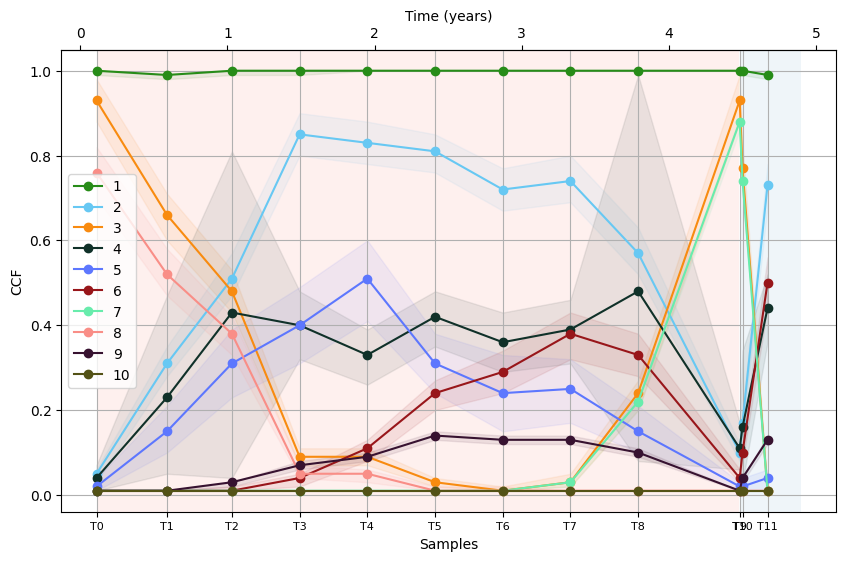

In [80]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_ccf(cluster_CCF_df,ax, times_sample )

In [81]:
def interpolate_abundance(abundance, mcmc, mode="interpolate_only"):
    """
    Parse abundance file and get abundance information and calculate interpolated abundance

    Args:
        cell_population_abundance file and mcmc_trace file
        mode: "interpolate_only" or "extrapolate"

    Returns:
        lists

    """

    cluster_map = {}

    # Get the cluster list from the mcmc file
    cluster_list = mcmc.Cluster_ID.unique().tolist()

    # Map the abundacne to each cluster in a dictionary
    for cluster_id in cluster_list:
        abundance['cluster'] = abundance['Cell_population'].str.split('_').str[-1].str[2:].astype(int)

        cluster_map[cluster_id] = abundance[abundance.cluster == cluster_id]

    ## To get abundance information from the cell_population_abundances.tsv
    cluster_abundance = {}
    for cluster_id, abundances in cluster_map.items():
        cluster_abundances = []
        ## iterate through the samples in the wbc file to make sure the order is correct
        for sample_name in sample_list:
            sample_abundances = float(abundances[abundances.Sample_ID == sample_name].Cell_abundance)
            cluster_abundances.append(sample_abundances / 100)
        cluster_abundance[cluster_id] = cluster_abundances

    ## To calculate interpolated abundance
    inter_abundance = {}
    for cluster_id, abundance in cluster_abundance.items():
        abundance_first = abundance[0]
        abundance_last = abundance[-1]
        if mode == "extrapolate":
            interpolate_func = interpolate.interp1d(times_sample, abundance, bounds_error=False,
                                                    fill_value=(abundance_first, abundance_last))
            abundance_interpolate = interpolate_func(times)

        if mode == "interpolate_only":
            interpolate_func = interpolate.interp1d(times_sample, abundance)

            abundance_interpolate = interpolate_func(times_interpolate)

        inter_abundance[cluster_id] = list(abundance_interpolate)

    return cluster_list, cluster_abundance, inter_abundance

In [82]:
cluster_list, cluster_abundance, inter_abundance = interpolate_abundance(abundance_df, mcmc_df)

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_77130/47543564.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sample_abundances = float(abundances[abundances.Sample_ID == sample_name].Cell_abundance)


In [83]:
cluster_abundance

{1: [0.0, 0.01, 0.0, 0.04, 0.03, 0.21, 0.29, 0.17, 0.15, 0.0, 0.04, 0.25],
 2: [0.0, 0.0, 0.0, 0.03, 0.0, 0.12, 0.09, 0.22, 0.19, 0.0, 0.0, 0.26],
 3: [0.18, 0.11, 0.08, 0.02, 0.04, 0.0, 0.0, 0.01, 0.01, 0.04, 0.04, 0.0],
 4: [0.01, 0.17, 0.51, 0.38, 0.27, 0.14, 0.03, 0.0, 0.0, 0.05, 0.07, 0.0],
 5: [0.02, 0.15, 0.0, 0.44, 0.5, 0.27, 0.28, 0.24, 0.15, 0.0, 0.0, 0.05],
 6: [0.0, 0.0, 0.0, 0.0, 0.0, 0.09, 0.17, 0.21, 0.19, 0.02, 0.07, 0.31],
 7: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.21, 0.87, 0.74, 0.01],
 8: [0.77, 0.53, 0.39, 0.05, 0.06, 0.02, 0.0, 0.01, 0.01, 0.01, 0.01, 0.0],
 9: [0.01, 0.01, 0.01, 0.03, 0.09, 0.14, 0.13, 0.12, 0.09, 0.01, 0.03, 0.12]}

In [84]:
def calc_subclone(wbc, inter_abundance, cluster_list, mode = "default" , input_type = "default", indexes = range(250)):
    
    """
    Calculate subclone abundance from interpolated abundance

    Args:
        wbc and inter_abundance
        mode: "default" or "positive (ensure positivity after taking the log)"
        input type: "default" or "mcmc (contains values of all iterations)"
    Returns:
        dictionaries

    """
    
    subclone_population = {}
    log_subclone ={}
    log_subclone_raw ={}
    
    if input_type == "default":
        for cluster_id in cluster_list:
            subclone_population[cluster_id] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id])]
            if mode == "default":
                log_subclone[cluster_id] = [np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [np.log(item*1000) for item in subclone_population[cluster_id]] 

            if mode == "positive":
                log_subclone[cluster_id] = [0 if item <1 else np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population[cluster_id]]

    if input_type == "mcmc":
        for cluster_id in cluster_list:
         
            subclone_population_per_iter = {}
            log_subclone_per_iter = {}
            log_subclone_raw_per_iter = {}
            
            for iter_idx in indexes:
                
                subclone_population_per_iter[iter_idx] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id][iter_idx])]
                if mode == "default":
                    log_subclone_per_iter[iter_idx] = [np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [np.log(item*1000) for item in subclone_population_per_iter[iter_idx]] 
                    
            subclone_population[cluster_id] = subclone_population_per_iter
            log_subclone[cluster_id] = log_subclone_per_iter
            log_subclone_raw[cluster_id] = log_subclone_raw_per_iter
                
    return subclone_population, log_subclone, log_subclone_raw

In [85]:
# calculate only at sample points
subclone_sample, log_subclone_sample, log_subclone_raw_sample = calc_subclone(wbc_sample, cluster_abundance, cluster_list, mode = "default")

In [86]:
def get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample):
    
    """
    Get cell abundance and interpolated cell abundance from all mcmc iterations

    Args:
        cluster_list, mcmc_df, sample_list
    Returns:
        a dictionary with key: cluster and value: 250 iterations of cell abundance

    """
    all_abundance = {}
    interpolated_all_abundance = {}
    for cluster in cluster_list:

        abundance_per_iter ={}
        inter_abundance_per_iter = {}
        for iter_idx in range(250):

            df_mcmc_iter_clust = mcmc_df[(mcmc_df.Iteration == iter_idx) & (mcmc_df.Cluster_ID == cluster) ]

            cluster_abundances = []
            ## iterate through the samples in the wbc file to make sure the order is correct
            for sample_name in sample_list:
                sample_abundance = float(df_mcmc_iter_clust[df_mcmc_iter_clust.Sample_ID == sample_name].Abundance)
                cluster_abundances.append(sample_abundance / 100)

            abundance_per_iter[iter_idx] = cluster_abundances
            
            
        all_abundance[cluster] = abundance_per_iter
        
    return all_abundance

In [87]:
all_abundance = get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_77130/2664756645.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sample_abundance = float(df_mcmc_iter_clust[df_mcmc_iter_clust.Sample_ID == sample_name].Abundance)


In [ ]:
# Add pseudocount (e.g., add 0.01 to all and normalize (divided by sum))

In [88]:
all_abundance[7]

{0: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.21, 0.88, 0.73, 0.0],
 1: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.22, 0.83, 0.75, 0.0],
 2: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.22, 0.87, 0.73, 0.0],
 3: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.21, 0.89, 0.73, 0.0],
 4: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.2, 0.89, 0.75, 0.0],
 5: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.02, 0.22, 0.87, 0.74, 0.0],
 6: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.22, 0.89, 0.74, 0.0],
 7: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.21, 0.87, 0.73, 0.01],
 8: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.02, 0.23, 0.89, 0.72, 0.01],
 9: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.23, 0.86, 0.73, 0.01],
 10: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.22, 0.87, 0.73, 0.01],
 11: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.22, 0.87, 0.73, 0.0],
 12: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.22, 0.86, 0.75, 0

# Filter out zero value abundance

In [68]:
filtered_indices = [key for key, value in all_abundance[7].items() if not any(v == 0 for v in value[6:10])]



In [69]:
for cluster, abundance in all_abundance.items():
    abundance = {key: value for key, value in abundance.items() if key in filtered_indices}
    all_abundance[cluster] = abundance

In [70]:
all_abundance

{1: {0: [0.03,
   0.04,
   0.01,
   0.06,
   0.08,
   0.12,
   0.28,
   0.24,
   0.16,
   0.0,
   0.11,
   0.24],
  1: [0.0, 0.0, 0.05, 0.03, 0.02, 0.16, 0.22, 0.21, 0.21, 0.0, 0.0, 0.24],
  2: [0.05, 0.01, 0.0, 0.05, 0.11, 0.21, 0.31, 0.26, 0.18, 0.03, 0.04, 0.24],
  3: [0.07, 0.0, 0.0, 0.02, 0.0, 0.22, 0.23, 0.25, 0.17, 0.0, 0.0, 0.24],
  4: [0.02, 0.02, 0.0, 0.06, 0.08, 0.2, 0.25, 0.15, 0.28, 0.0, 0.06, 0.22],
  6: [0.03, 0.01, 0.04, 0.02, 0.12, 0.18, 0.25, 0.21, 0.06, 0.02, 0.02, 0.3],
  7: [0.04, 0.0, 0.06, 0.07, 0.05, 0.16, 0.3, 0.17, 0.24, 0.0, 0.08, 0.24],
  9: [0.02, 0.01, 0.04, 0.05, 0.05, 0.16, 0.25, 0.27, 0.16, 0.0, 0.1, 0.3],
  10: [0.0, 0.04, 0.0, 0.02, 0.09, 0.13, 0.26, 0.22, 0.22, 0.02, 0.04, 0.25],
  11: [0.01, 0.03, 0.03, 0.03, 0.14, 0.15, 0.28, 0.22, 0.24, 0.02, 0.1, 0.29],
  12: [0.0, 0.0, 0.0, 0.1, 0.07, 0.17, 0.3, 0.22, 0.2, 0.0, 0.06, 0.26],
  14: [0.0, 0.04, 0.0, 0.08, 0.11, 0.26, 0.24, 0.28, 0.1, 0.0, 0.02, 0.26],
  16: [0.01, 0.0, 0.0, 0.05, 0.08, 0.16, 0.29, 

In [61]:
subclone_sample_mcmc, log_subclone_sample_mcmc, log_subclone_raw_sample_mcmc = calc_subclone(wbc_sample, all_abundance, cluster_list, mode = "default", input_type = "mcmc", indexes = filtered_indices)

In [25]:
def slice_wbc(dfd_first, dfd_last, times, wbc, times_sample):
    '''
    select wbc between the two dfds 

    
    '''
    last_sample_time = times_sample[-1]

    times_selected = [time_ for time_ in times if time_ <= dfd_last and time_ >=dfd_first]

    smallest_times_selected = min(times_selected)
    largest_times_selected = max(times_selected)

    smallest_index = times.index(smallest_times_selected)
    largest_index = times.index(largest_times_selected)

    wbc_selected = wbc[smallest_index: largest_index+ 1]

    return times_selected, wbc_selected

In [26]:
times_sample

[40, 215, 376, 544, 712, 880, 1048, 1216, 1384, 1636, 1643, 1705]

In [27]:
# Select the time period where exponential pattern is assumed 

exp_sample_start = 6
exp_sample_end = 9


In [34]:
times_sample[exp_sample_start], times_sample[exp_sample_end]

(1048, 1636)

In [28]:
times_sliced, wbc_sliced = slice_wbc(times_sample[exp_sample_start], times_sample[exp_sample_end], times, wbc, times_sample)

In [35]:
times_sliced

[1048, 1134, 1216, 1315, 1384, 1552, 1622, 1630, 1636]

1 [np.float64(0.9338072185293127), np.float64(0.5733174894323602), np.float64(1.023477019794988), np.float64(-4.8422858948691845)]
1 [-3.43435999 11.85163937]
2 [np.float64(-0.23549830798375326), np.float64(0.8310129785629599), np.float64(1.2597255306499553), np.float64(-4.8422858948691845)]
2 [-2.8405958   9.53386063]
3 [np.float64(-7.0390035655920915), np.float64(-2.250533586122242), np.float64(-1.6752892949972142), np.float64(1.1516755324373849)]
3 [  4.67048036 -19.35658788]
4 [np.float64(-1.3318933008432154), np.float64(-6.865654102963502), np.float64(-6.290409811838473), np.float64(1.3743202062156805)]
4 [  2.1680081  -11.12481666]
5 [np.float64(0.8987282096680175), np.float64(0.9179864932577515), np.float64(1.023477019794988), np.float64(-4.8422858948691845)]
5 [-3.48582539 12.11529932]
6 [np.float64(0.39996802680377064), np.float64(0.7845145978814987), np.float64(1.2597255306499553), np.float64(0.4610190131898912)]
6 [0.06385081 0.49521932]
7 [np.float64(-2.423883048750832), np

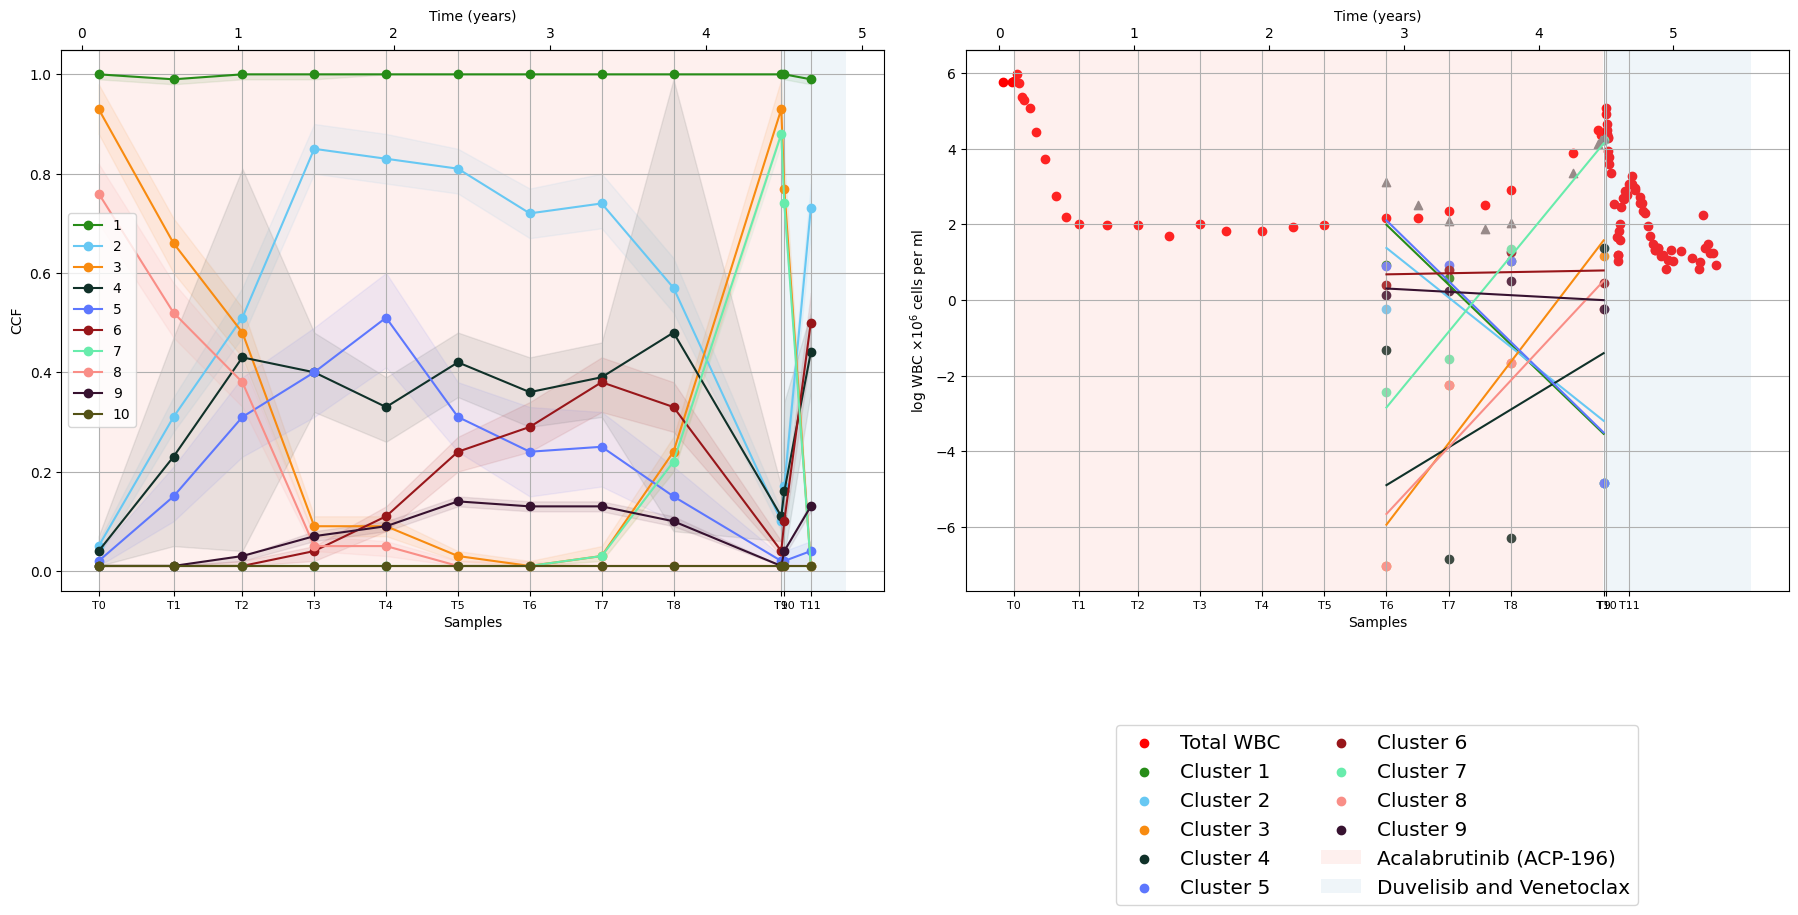

In [29]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')



    cluster_cell_population = {}
    for i in clusters:
        
        
        
         # Interpolate during treatment 

        exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
        exp_year = [ i/365 for i in np.array(exp_times)]
        exp_subclone = log_subclone_sample[i][exp_sample_start : exp_sample_end + 1 ]
        print(i, exp_subclone)
        
        ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)
        
        model = np.polyfit(exp_year, exp_subclone, 1)
        print(i, model)

        predict_x = times_sliced
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5,6,7,8,9])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

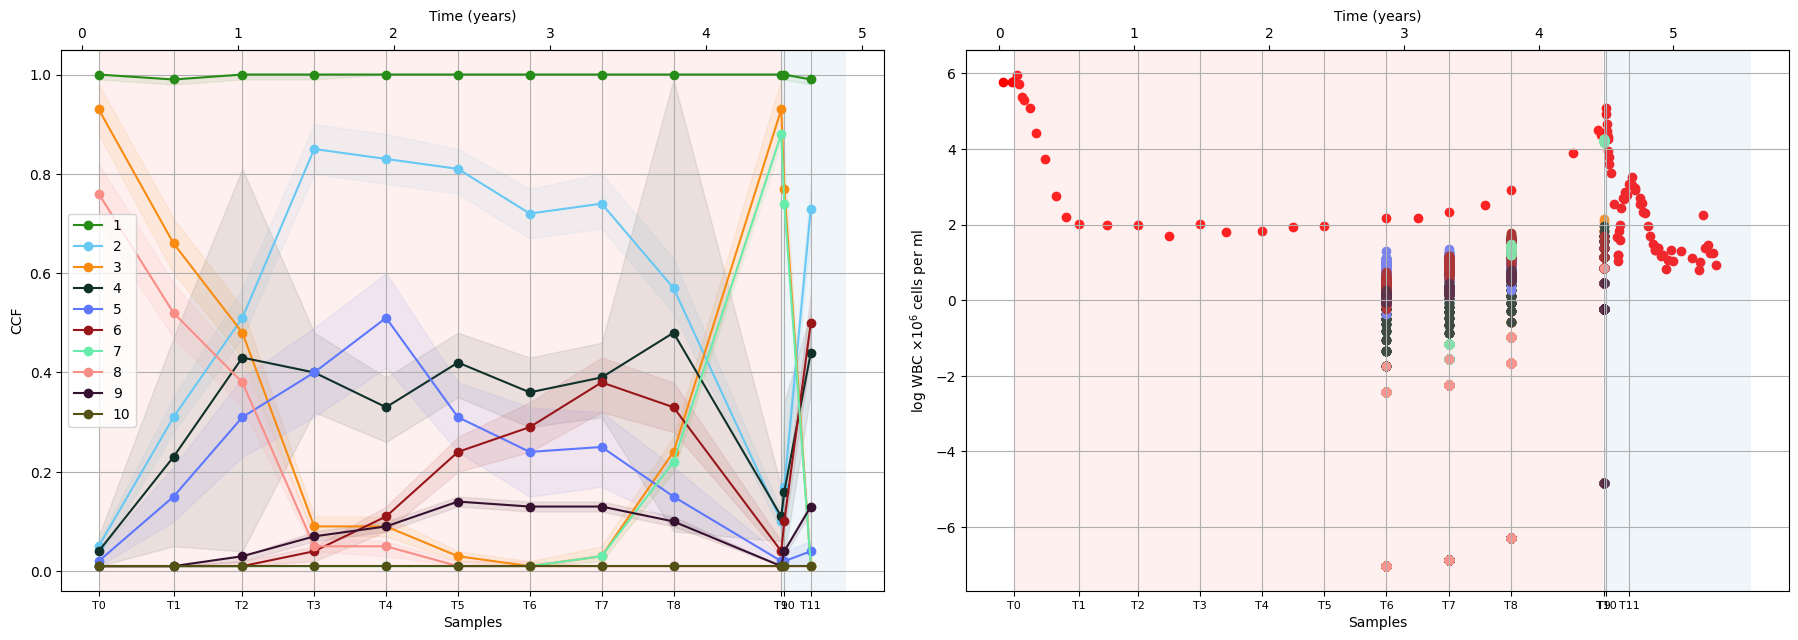

In [63]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]
BTK_rate_mcmc = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')


    
    cluster_cell_population = {}
    for i in clusters:
        
        for iter_idx in filtered_indices:
        
         # Interpolate during treatment 

            exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
            exp_year = [ i/365 for i in np.array(exp_times)]
            exp_subclone = log_subclone_sample_mcmc[i][iter_idx][exp_sample_start : exp_sample_end + 1 ]


            ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)

            model = np.polyfit(exp_year, exp_subclone, 1)
            
            if i ==7:
                
                BTK_rate_mcmc.append(model[0])
    
      

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5,6,7,8,9])
# ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

In [64]:
lower_ci = np.percentile(BTK_rate_mcmc, 2.5, axis=0)
upper_ci = np.percentile(BTK_rate_mcmc, 97.5, axis=0)
mean = np.mean(BTK_rate_mcmc)

In [65]:
BTK_rate_mcmc

[np.float64(4.345503004825691),
 np.float64(4.233547252086707),
 np.float64(4.344206917559176),
 np.float64(4.352385300692796),
 np.float64(4.264452062262112),
 np.float64(4.358050156817206),
 np.float64(4.338542061434766),
 np.float64(4.482313434844461),
 np.float64(4.344206917559176),
 np.float64(4.344206917559176),
 np.float64(4.3371655083547225),
 np.float64(4.3184357323487585),
 np.float64(4.471235466868998),
 np.float64(4.483941732197863),
 np.float64(4.331500652230312),
 np.float64(4.352385300692796),
 np.float64(4.325559489451485),
 np.float64(4.263510929173833),
 np.float64(4.352385300692796),
 np.float64(4.358050156817206),
 np.float64(4.483941732197863),
 np.float64(4.338542061434766),
 np.float64(4.344206917559176),
 np.float64(4.250608823004082),
 np.float64(4.269175785298244),
 np.float64(4.276058081165349),
 np.float64(4.331500652230312),
 np.float64(4.354802823054368),
 np.float64(4.3591907063817565),
 np.float64(4.333614925252474),
 np.float64(4.257569766395007),
 np.f

In [66]:
lower_ci, mean, upper_ci

(np.float64(4.24925326890725),
 np.float64(4.332232692011508),
 np.float64(4.493111465153254))

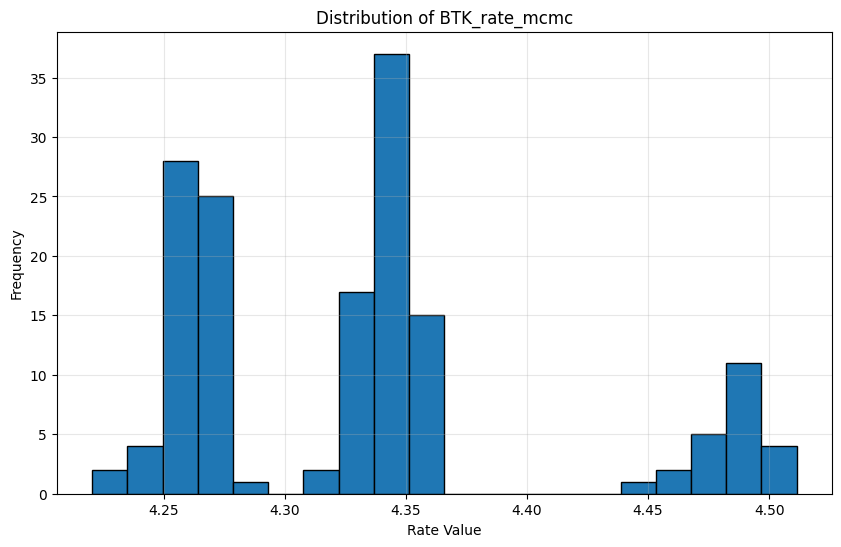

95% Confidence Interval: 4.33 (4.25, 4.49)


In [67]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(BTK_rate_mcmc, bins=20, edgecolor='black')
plt.title('Distribution of BTK_rate_mcmc')
plt.xlabel('Rate Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(f"95% Confidence Interval: {mean:.2f} ({lower_ci:.2f}, {upper_ci:.2f})")